In [2]:
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import pandas as pd
from numpy import array
import seaborn as sns
import matplotlib.pyplot as plt
import functions as fu

In [ ]:
from google.colab import drive 
drive.mount("/content/gdrive")

df=pd.read_csv("gdrive/My Drive/train_data_clean")

In [3]:
train_data = pd.read_csv('/Users/aitormentxaka/Desktop/Data science/proyectos/Modelo machine learning regresión/house-prices-advanced-regression-techniques/train.csv')


In [27]:
fu.distribucion(train_data["SalePrice"])

AttributeError: module 'functions' has no attribute 'distribucion'

## 1.Descripción de los datos 

Partimos ua base de datos que contiene 81 características (columnas) de 1460 casas de la ciudad estadounidense Ames, Lowa. Nuestra variable target es el precio de la vivienda (Sale_Price), variable que tenemos por objetivo predecir a partir de un modelo de regresión. 

## 2.Análisis exploratorio de datos (EDA)

# 2.1 Valores faltantes 

In [3]:
# Obtener el recuento de valores nulos por columna
recuento_nulos = train_data.isnull().sum()
recuento_nulos= pd.DataFrame(recuento_nulos)

recuento_nulos



,0
Id,0
MSSubClass,0
MSZoning,0
LotFrontage,259
LotArea,0
...,...
MoSold,0
YrSold,0
SaleType,0
SaleCondition,0


Como vemos, hay varias varibles con una cantidad de datos faltantes muy considerable. En concreto, las siguientes 6 variables son las más problemáticas: Alley, MasVnrType, FireplaceQu, PoolQC, Fence, MiscFeature. 

In [5]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
"""Tratamiento de valores faltantes: identificamos varias variables en los Nan significa simplemente la ausencia de esa característica 
en la casa; en tal caso cambiaremos simplemente por None o 0, en función de si la variable está discretizada o no. En el caso de variables categoricas con algún Nan que no signifique ausencia sustituimos por la moda, en el caso de las 
numéricas por la media."""

train_data["Alley"].fillna("None", inplace=True)
train_data["FireplaceQu"].fillna("None", inplace=True)
train_data["PoolQC"].fillna("None", inplace=True)
train_data["Fence"].fillna("None", inplace=True)
train_data["MiscFeature"].fillna("None", inplace=True)
train_data["MasVnrType"].fillna("None", inplace=True)
train_data["MasVnrArea"].fillna(0, inplace=True)

train_data["BsmtQual"].fillna("None", inplace=True)
train_data["BsmtCond"].fillna("None", inplace=True)
train_data["BsmtExposure"].fillna("None", inplace=True)
train_data["BsmtFinType1"].fillna("None", inplace=True)
train_data["BsmtFinType2"].fillna("None", inplace=True)

train_data["GarageFinish"].fillna("None", inplace=True)
train_data["GarageType"].fillna("None", inplace=True)
train_data["GarageQual"].fillna("None", inplace=True)
train_data["GarageCond"].fillna("None", inplace=True)
train_data["GarageYrBlt"].fillna("None", inplace=True)


train_data["LotFrontage"].fillna(train_data["LotFrontage"].mean(), inplace=True)

train_data["MSZoning"].fillna(train_data["MSZoning"].mode()[0], inplace=True)
train_data["Electrical"].fillna(train_data["Electrical"].mode()[0], inplace=True)
train_data["Utilities"].fillna(train_data["Utilities"].mode()[0], inplace=True)
train_data["Functional"].fillna(train_data["Functional"].mode()[0], inplace=True)
train_data["SaleType"].fillna(train_data["SaleType"].mode()[0], inplace=True)


NameError: name 'train_data' is not defined

In [5]:
train_data.isnull().sum()

Id               0
MSSubClass       0
MSZoning         0
LotFrontage      0
LotArea          0
                ..
MoSold           0
YrSold           0
SaleType         0
SaleCondition    0
SalePrice        0
Length: 81, dtype: int64

## 2.2 Estadísticos de varibles numéricas y categoricas

In [8]:
#Hacemos una copia de los datos para utilizarlos más adelante 
train_data2=train_data.copy()
#Separamos las variables numéricas y categoricas
var_cat = train_data.select_dtypes(include=['object'])
var_num = pd.DataFrame(train_data.select_dtypes(exclude=['object']))

#Metemos la variable target en las categóricas para anális posteriores 

var_cat["SalePrice"]= train_data["SalePrice"]

In [9]:
#vemos los estadísticos simples de las variables numéricas 
var_num.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.117123,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,22.024023,9981.264932,1.382997,1.112799,30.202904,20.645407,180.731373,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,60.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,70.049958,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,79.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,164.250000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [10]:
"""# Ahora vemos sus histogramas 
for column in var_num.select_dtypes(include='number').columns:
    sns.histplot(var_num[column], bins=10, kde=False)
    plt.title(f'Histograma de {column}')
    plt.xlabel(column)
    plt.ylabel('Frecuencia')
    plt.show()"""

"# Ahora vemos sus histogramas \nfor column in var_num.select_dtypes(include='number').columns:\n    sns.histplot(var_num[column], bins=10, kde=False)\n    plt.title(f'Histograma de {column}')\n    plt.xlabel(column)\n    plt.ylabel('Frecuencia')\n    plt.show()"

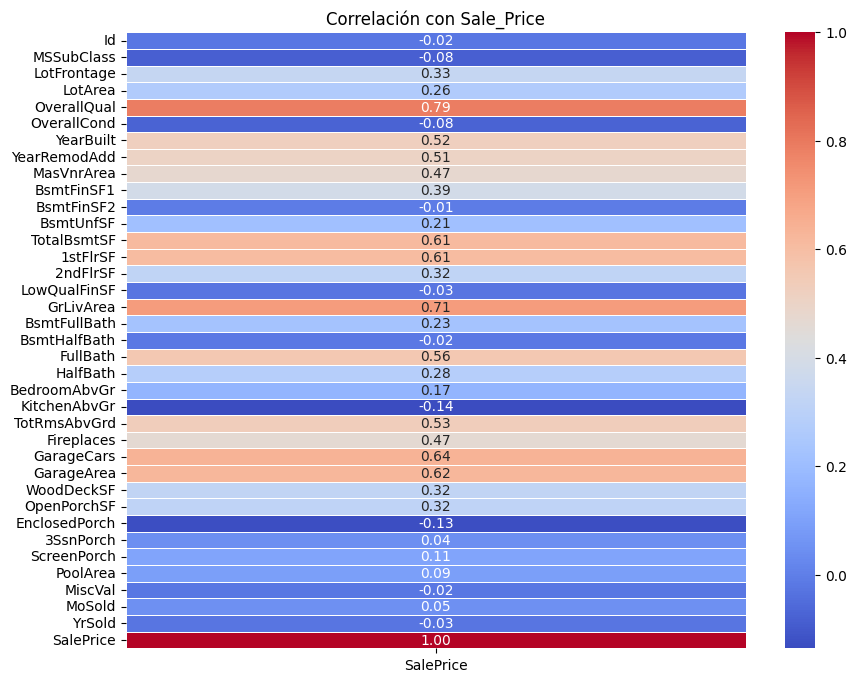

In [11]:


matriz_correlacion_num = var_num.corr()
correlacion_con_sale_price = matriz_correlacion_num['SalePrice']
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion_con_sale_price.to_frame(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlación con Sale_Price")
plt.show()


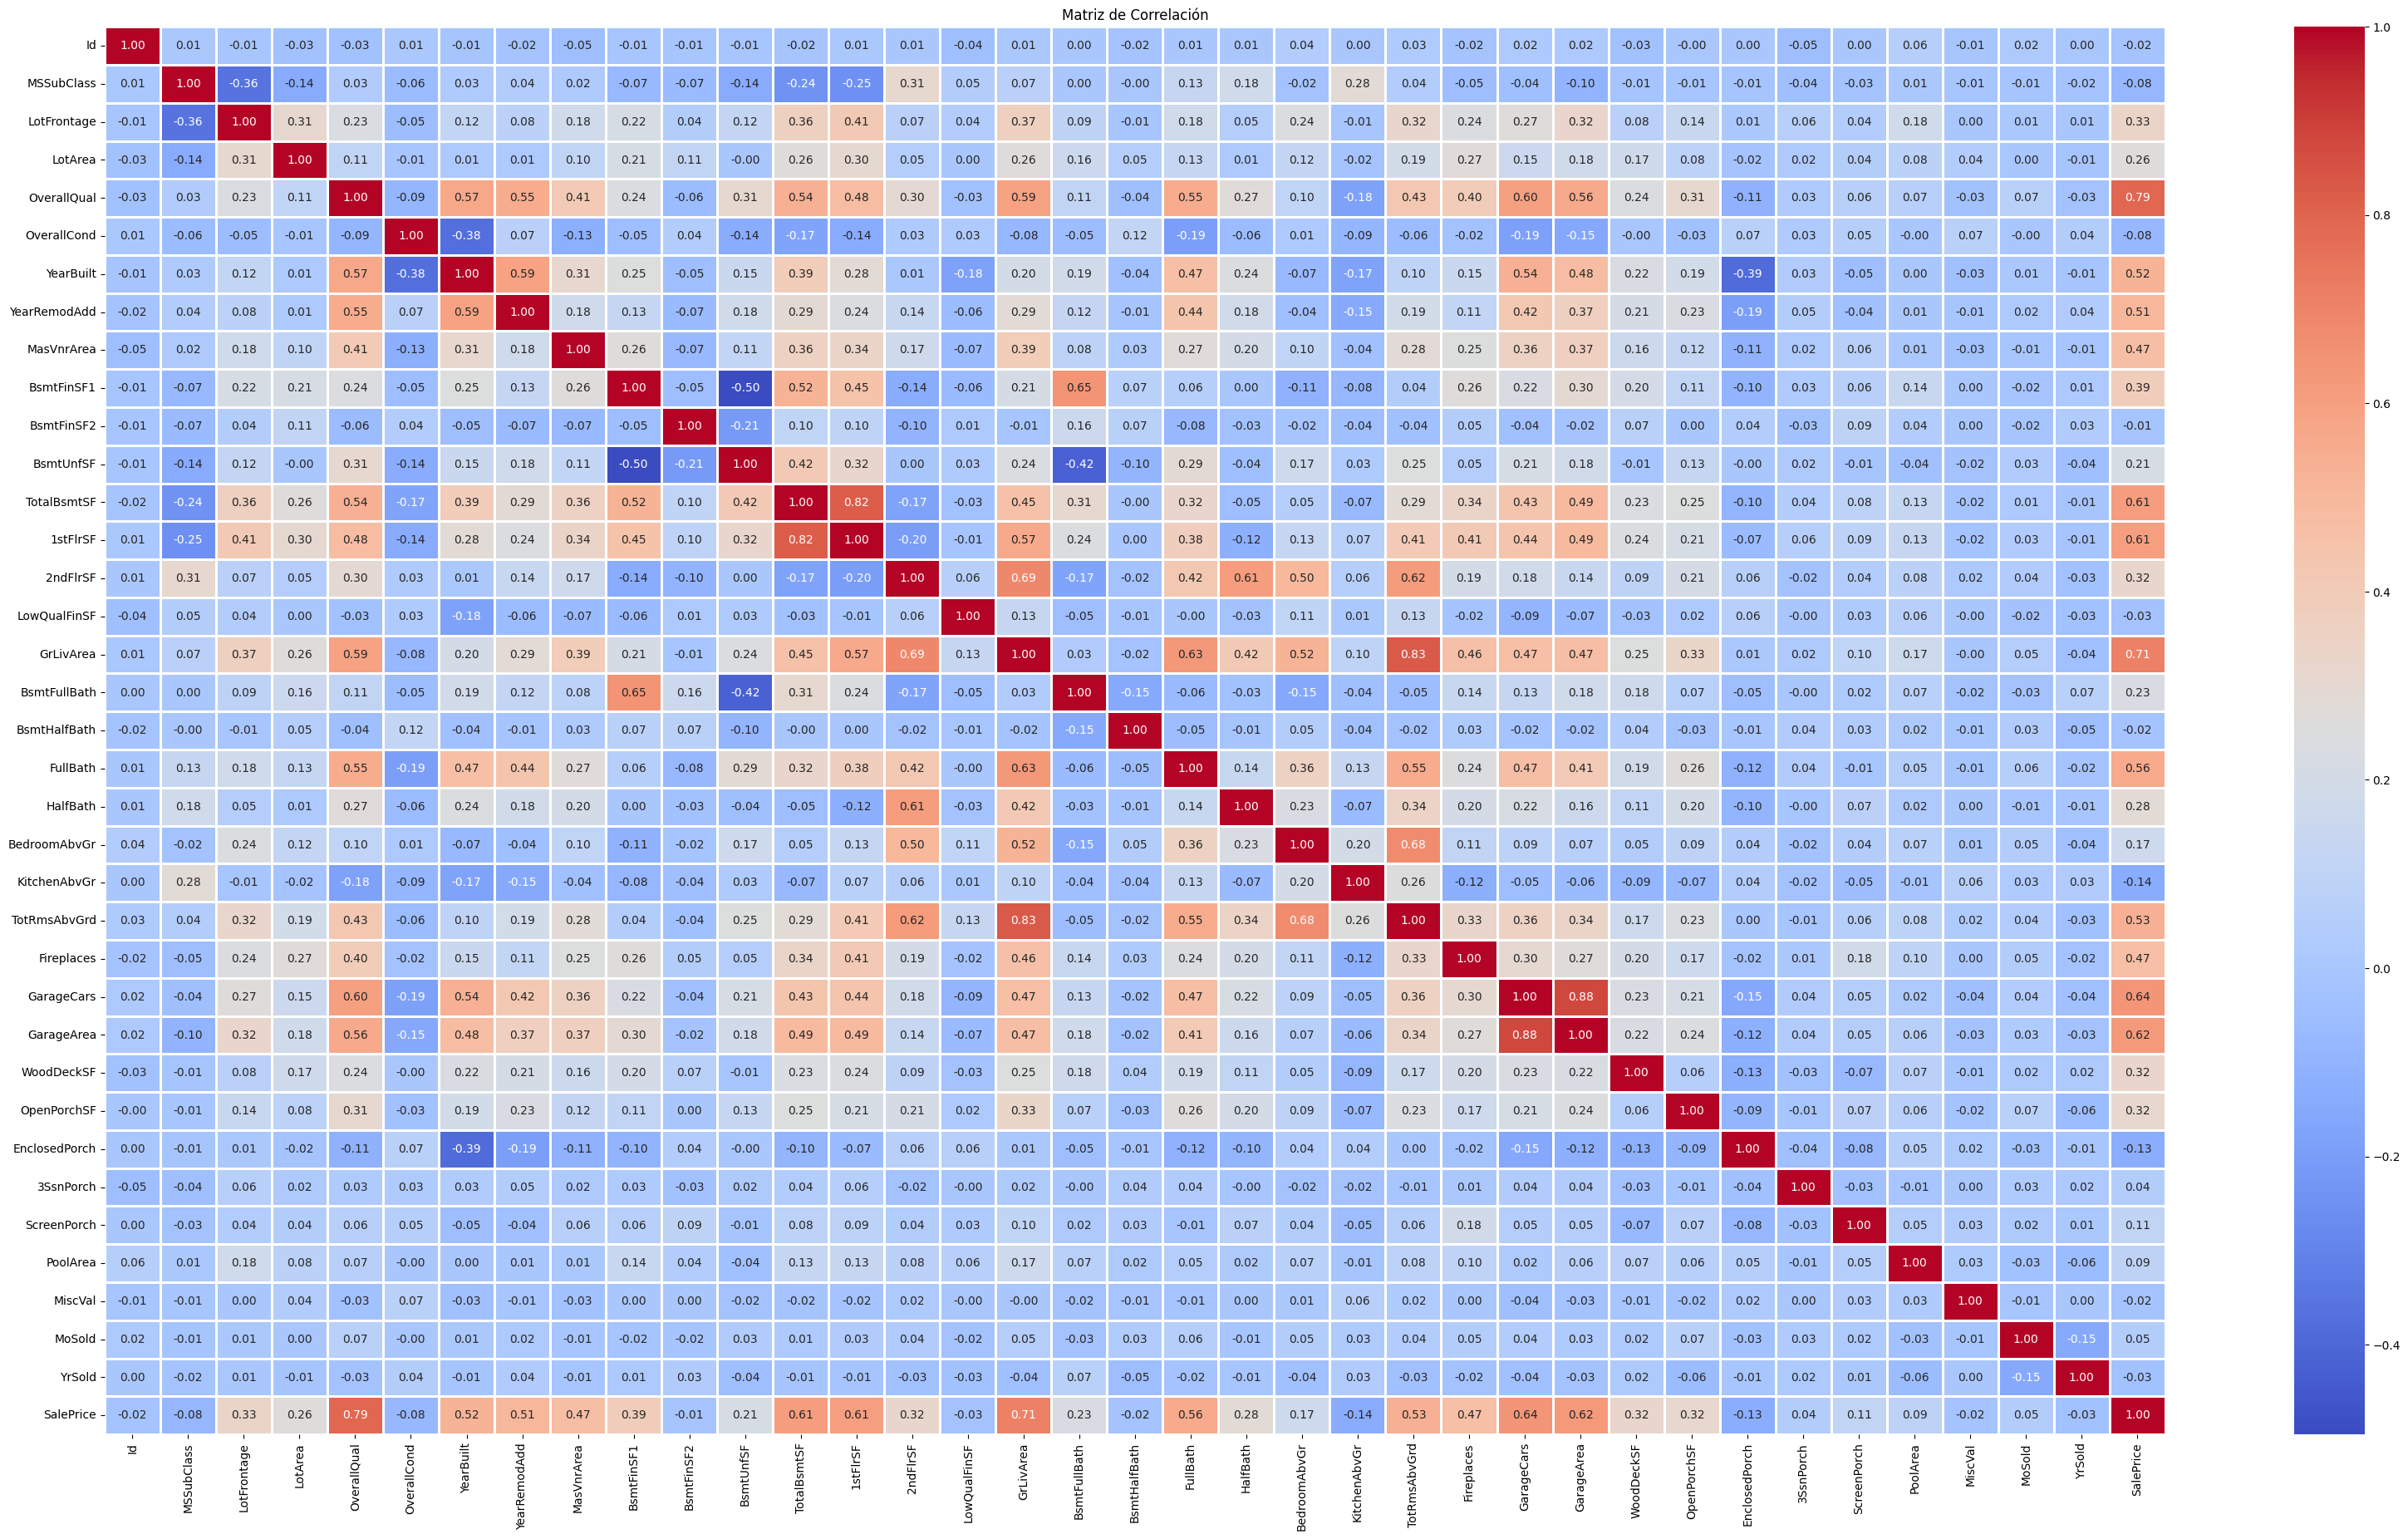

In [12]:

plt.figure(figsize=(40, 22))
sns.heatmap(matriz_correlacion_num, annot=True, cmap='coolwarm', fmt=".2f", linewidths=1)
plt.title("Matriz de Correlación")
plt.show()

In [76]:
#Veamos las mejores regresoras 
mascara=matriz_correlacion_num['SalePrice']>0.3 
matriz_correlacion_num['SalePrice'][mascara]

LotFrontage     0.334901
OverallQual     0.790982
YearBuilt       0.522897
YearRemodAdd    0.507101
MasVnrArea      0.472614
BsmtFinSF1      0.386420
TotalBsmtSF     0.613581
1stFlrSF        0.605852
2ndFlrSF        0.319334
GrLivArea       0.708624
FullBath        0.560664
TotRmsAbvGrd    0.533723
Fireplaces      0.466929
GarageCars      0.640409
GarageArea      0.623431
WoodDeckSF      0.324413
OpenPorchSF     0.315856
SalePrice       1.000000
Name: SalePrice, dtype: float64

## 2.4 Variables categóricas 
 Veamos ahora la correlación de las variables categóricas 

In [14]:
"""import seaborn as sns
import matplotlib.pyplot as plt

variables_categoricas = var_cat.columns.difference(['SalePrice'])

plt.figure(figsize=(6, 6))
for variable in variables_categoricas:
    sns.boxplot(x=variable, y='SalePrice', data=var_cat)
    plt.title(f'Boxplot de {variable} respecto a SalePrice')
    plt.show()"""



"import seaborn as sns\nimport matplotlib.pyplot as plt\n\nvariables_categoricas = var_cat.columns.difference(['SalePrice'])\n\nplt.figure(figsize=(6, 6))\nfor variable in variables_categoricas:\n    sns.boxplot(x=variable, y='SalePrice', data=var_cat)\n    plt.title(f'Boxplot de {variable} respecto a SalePrice')\n    plt.show()"

## Discretización de variables

En esta sección tranformaremos las variables categóricas susceptibles de orden por números. Aismismo, aqellas variables dicotómicas relevantes las cambiaremos por 0 y 1. En los casos en los que se observe cierta relación entre alguna variable categórica y la varibale target (a prtir de los gräficos de la sección amterior), asumiremos el orden viendo como le afecta al precio de la vivienda en términos medios. 

In [6]:
#Cambiammos la varible HeatingQC y Heating, que se refire a la calidad de la calefacción y al tipo ordenado de mejor a peor, a números 
dic_HeatingQC= {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
dic_Heating={'GasA': 6, 'GasW': 5, 'OthW': 4, 'Wall': 3, 'Grav': 2, 'Floor': 1}
train_data['HeatingQC']= train_data['HeatingQC'].replace(dic_HeatingQC)
train_data['Heating']= train_data['Heating'].replace(dic_Heating)
train_data[['HeatingQC','Heating']]

,HeatingQC,Heating
0,5,6
1,5,6
2,5,6
3,4,6
4,5,6
...,...,...
1455,5,6
1456,3,6
1457,5,6
1458,4,6


In [7]:

dic_Alley = {"Grvl": 1, "Pave": 2, "None": 0}
train_data['Alley'] = train_data['Alley'].replace(dic_Alley)

dic_BsmtCond = {"No_Bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
train_data['BsmtCond'] = train_data['BsmtCond'].replace(dic_BsmtCond)

dic_BsmtExposure = {"No_Bsmt": 0, "Mn": 1, "Av": 2, "Gd": 3, "No": 0}
train_data['BsmtExposure'] = train_data['BsmtExposure'].replace(dic_BsmtExposure)

dic_BsmtFinType1 = {"No_Bsmt": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
train_data['BsmtFinType1'] = train_data['BsmtFinType1'].replace(dic_BsmtFinType1)

dic_BsmtFinType2 = {"No_Bsmt": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
train_data['BsmtFinType2'] = train_data['BsmtFinType2'].replace(dic_BsmtFinType2)

dic_BsmtQual = {"No_Bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
train_data['BsmtQual'] = train_data['BsmtQual'].replace(dic_BsmtQual)

dic_ExterCond = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
train_data['ExterCond'] = train_data['ExterCond'].replace(dic_ExterCond)

dic_ExterQual = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
train_data['ExterQual'] = train_data['ExterQual'].replace(dic_ExterQual)

dic_GarageCond = {"No_Garage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
train_data['GarageCond'] = train_data['GarageCond'].replace(dic_GarageCond)

dic_GarageQual = {"No_Garage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
train_data['GarageQual'] = train_data['GarageQual'].replace(dic_GarageQual)

dic_PoolQC = {"None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
train_data['PoolQC'] = train_data['PoolQC'].replace(dic_PoolQC)

dic_Functional = {"Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}
train_data['Functional'] = train_data['Functional'].replace(dic_Functional)

dic_KitchenQual = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
train_data['KitchenQual'] = train_data['KitchenQual'].replace(dic_KitchenQual)

dic_LandSlope = {"Sev": 1, "Mod": 2, "Gtl": 3}
train_data['LandSlope'] = train_data['LandSlope'].replace(dic_LandSlope)

dic_LotShape = {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4}
train_data['LotShape'] = train_data['LotShape'].replace(dic_LotShape)

dic_PavedDrive = {"N": 0, "P": 1, "Y": 2}
train_data['PavedDrive'] = train_data['PavedDrive'].replace(dic_PavedDrive)

dic_Street = {"Grvl": 1, "Pave": 2}
train_data['Street'] = train_data['Street'].replace(dic_Street)

dic_Utilities = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
train_data['Utilities'] = train_data['Utilities'].replace(dic_Utilities)



In [17]:
precio_medio_por_categoria = train_data.groupby('SaleType')['SalePrice'].mean()
print(precio_medio_por_categoria.sort_values(ascending=False))

SaleType
New      274945.418033
Con      269600.000000
CWD      210600.000000
ConLI    200390.000000
WD       173401.836622
COD      143973.255814
ConLw    143700.000000
ConLD    138780.888889
Oth      119850.000000
Name: SalePrice, dtype: float64


In [8]:
dic_SaleType= {"New": 1, "Con": 2, "CWD": 3, "ConLI": 4,"WD": 5, "COD": 6, "ConLw": 7, "ConLD": 8, "Oth":9 }
train_data['SaleType'] = train_data['SaleType'].replace(dic_SaleType)

In [19]:
train_data["SaleType"]

0       5
1       5
2       5
3       5
4       5
       ..
1455    5
1456    5
1457    5
1458    5
1459    5
Name: SaleType, Length: 1460, dtype: int64

In [7]:
precio_medio_por_categoria = train_data.groupby('SaleCondition')['SalePrice'].mean()
print(precio_medio_por_categoria.sort_values(ascending=False))

SaleCondition
Partial    272291.752000
Normal     175202.219533
Alloca     167377.416667
Family     149600.000000
Abnorml    146526.623762
AdjLand    104125.000000
Name: SalePrice, dtype: float64


In [9]:
dic_SaleCondition= {"Partial": 1, "Normal": 2, "Alloca": 3, "Family": 4,"Abnorml": 5, "Adjand": 6}
train_data['SaleCondition'] = train_data['SaleCondition'].replace(dic_SaleCondition)


In [9]:
train_data[["BsmtExposure","BsmtFinSF1","BsmtFinSF2"]]

,BsmtExposure,BsmtFinSF1,BsmtFinSF2
0,0,706,0
1,3,978,0
2,1,486,0
3,0,216,0
4,2,655,0
...,...,...,...
1455,0,0,0
1456,0,790,163
1457,0,275,0
1458,1,49,1029


In [10]:
#id como indice 

train_data=train_data.set_index("Id")

In [11]:
train_data

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,2,0,4,Lvl,4,Inside,...,0,0,None,None,0,2,2008,5,2,208500
2,20,RL,80.0,9600,2,0,4,Lvl,4,FR2,...,0,0,None,None,0,5,2007,5,2,181500
3,60,RL,68.0,11250,2,0,3,Lvl,4,Inside,...,0,0,None,None,0,9,2008,5,2,223500
4,70,RL,60.0,9550,2,0,3,Lvl,4,Corner,...,0,0,None,None,0,2,2006,5,5,140000
5,60,RL,84.0,14260,2,0,3,Lvl,4,FR2,...,0,0,None,None,0,12,2008,5,2,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,2,0,4,Lvl,4,Inside,...,0,0,None,None,0,8,2007,5,2,175000
1457,20,RL,85.0,13175,2,0,4,Lvl,4,Inside,...,0,0,MnPrv,None,0,2,2010,5,2,210000
1458,70,RL,66.0,9042,2,0,4,Lvl,4,Inside,...,0,0,GdPrv,Shed,2500,5,2010,5,2,266500


## Variables Dummies 

Otra manera de tratar a las variables categóricas es mediante las variables dummies. Se crea una nueva variable por cada categoria de las variables categóricas, y se rellena de 0 y 1 en función de si pertenece a esa categoría o no. Probaremos a relizarlo de esta manera, y comporaremos los resultados. 

In [12]:
# Obtención de variables categóricas.
dummies_cols = train_data.select_dtypes(include=object).columns
dummies = pd.get_dummies(train_data[dummies_cols],dtype=int) # One Hot Encoding

# Obtención de variables numéricas.
int_cols = train_data.select_dtypes(include = ['float64','int64']).columns
int_cols = int_cols[int_cols != "SalePrice"]

train_data = pd.concat([train_data.loc[:1460, int_cols].dropna(), dummies.loc[:1460, :].dropna(), train_data["SalePrice"].dropna()], axis=1)


In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 1 to 1460
Columns: 353 entries, MSSubClass to SalePrice
dtypes: float64(2), int64(351)
memory usage: 3.9 MB


In [78]:
train_data.to_csv("train_data_clean")

## Modelo

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import sklearn.linear_model
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import RobustScaler
from sklearn import metrics
from sklearn.metrics import r2_score

In [53]:
train_data=pd.read_csv("/Users/aitormentxaka/Desktop/Data science/proyectos/Modelo machine learning regresión/train_data_clean")

In [54]:
train_data=train_data.set_index("Id")

In [55]:
train_data

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_AdjLand,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,2,0,4,4,3,7,5,...,0,0,0,0,1,0,0,0,0,208500
2,20,80.0,9600,2,0,4,4,3,6,8,...,0,0,0,0,1,0,0,0,0,181500
3,60,68.0,11250,2,0,3,4,3,7,5,...,0,0,0,0,1,0,0,0,0,223500
4,70,60.0,9550,2,0,3,4,3,7,5,...,0,0,0,0,0,0,0,1,0,140000
5,60,84.0,14260,2,0,3,4,3,8,5,...,0,0,0,0,1,0,0,0,0,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,2,0,4,4,3,6,5,...,0,0,0,0,1,0,0,0,0,175000
1457,20,85.0,13175,2,0,4,4,3,6,6,...,0,0,0,0,1,0,0,0,0,210000
1458,70,66.0,9042,2,0,4,4,3,7,9,...,0,1,0,0,1,0,0,0,0,266500


In [56]:
def aplicar_logaritmo(df):
    df_copy = df.copy()
    for col in df.columns:
        unique_values = df[col].nunique()
        if unique_values > 10 and all(df[col] > 0):
            df_copy[col] = np.log1p(df[col])
    return df_copy


In [57]:
train_data=aplicar_logaritmo(train_data)

In [58]:
train_data

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_AdjLand,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,4.110874,4.189655,9.042040,2,0,4,4,3,7,5,...,0,0,0,0,1,0,0,0,0,12.247699
2,3.044522,4.394449,9.169623,2,0,4,4,3,6,8,...,0,0,0,0,1,0,0,0,0,12.109016
3,4.110874,4.234107,9.328212,2,0,3,4,3,7,5,...,0,0,0,0,1,0,0,0,0,12.317171
4,4.262680,4.110874,9.164401,2,0,3,4,3,7,5,...,0,0,0,0,0,0,0,1,0,11.849405
5,4.110874,4.442651,9.565284,2,0,3,4,3,8,5,...,0,0,0,0,1,0,0,0,0,12.429220
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,4.110874,4.143135,8.976894,2,0,4,4,3,6,5,...,0,0,0,0,1,0,0,0,0,12.072547
1457,3.044522,4.454347,9.486152,2,0,4,4,3,6,6,...,0,0,0,0,1,0,0,0,0,12.254868
1458,4.262680,4.204693,9.109746,2,0,4,4,3,7,9,...,0,1,0,0,1,0,0,0,0,12.493133


In [59]:

X = train_data.iloc[:,:-1]
y = train_data['SalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
y

Id
1       12.247699
2       12.109016
3       12.317171
4       11.849405
5       12.429220
          ...    
1456    12.072547
1457    12.254868
1458    12.493133
1459    11.864469
1460    11.901590
Name: SalePrice, Length: 1460, dtype: float64

In [61]:
X_train

,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,OverallCond,...,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_AdjLand
Id,,,,,,,,,,,,,,,,,,,,,
255,3.044522,4.262680,9.036106,2,0,4,4,3,5,6,...,1,0,0,0,0,1,0,0,0,0
1067,4.110874,4.094345,8.966739,2,0,3,4,3,6,7,...,1,0,0,0,0,1,0,0,0,0
639,3.433987,4.219508,9.080004,2,0,4,4,3,5,7,...,1,0,0,0,0,1,0,0,0,0
800,3.931826,4.110874,8.881975,2,0,4,4,3,5,7,...,1,0,0,0,0,1,0,0,0,0
381,3.931826,3.931826,8.517393,2,2,4,4,3,5,6,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1096,3.044522,4.369448,9.139703,2,0,3,4,3,6,5,...,1,0,0,0,0,1,0,0,0,0
1131,3.931826,4.189655,8.962520,2,0,4,4,3,4,3,...,1,0,0,0,0,1,0,0,0,0
1295,3.044522,4.110874,9.008591,2,0,4,4,3,5,7,...,1,0,0,0,0,1,0,0,0,0


In [21]:
def cross_validation(model):
    scores = np.sqrt(-cross_val_score(model, X_train, y_train, cv = 12, scoring = "neg_mean_squared_error"))
    mean = np.mean(scores)
    print("Mean CV score: ",mean)

In [22]:
def rmse(y_pred, y_train): 
    rmse_ = np.sqrt(metrics.mean_squared_error(y_pred,y_train))
    print("rmse: ", rmse_)

In [25]:
def actual_vs_pred_plot(y_train,y_pred):
    fig = plt.figure(figsize=(12,12))
    fig, ax = plt.subplots()
    ax.scatter(y_train, y_pred,color = "red",edgecolor = 'black')
    ax.plot([y_train.min(),y_train.max()], [y_train.min(), y_train.max()], 'k--',lw=0.2)
    ax.set_xlabel('Real')
    ax.set_ylabel('Predicción')
    plt.suptitle("Gráfico de dispersión real frente a predicción",size=14)
    plt.show()

Mean CV score:  0.13024638803407484
rmse:  0.1311154425338026
R-cuadrado: 0.91


<Figure size 1200x1200 with 0 Axes>

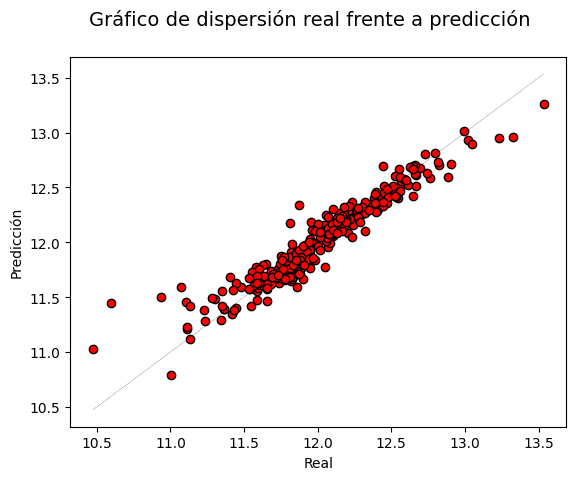

In [67]:
#Para buscar el mejor valor de alphas de esta lista usaré RidgeCV
alphas_ = [30]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=alphas_, ))

# Calcular su validación cruzada

cross_validation(ridge)
pesos=y_train
#fit
model_ridge = ridge.fit(X_train, y_train)

#Predecimos el valor de SalePrice en el df de test
y2_pred_v = ridge.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y2_pred_v, y_test)

# Calculamos coeficiente de determinación (R-cuadrado) 
y2_pred_v = ridge.predict(X_test)
r2 = r2_score(y_test, y2_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y2_pred_v)

In [256]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import mean_squared_error, r2_score

# Definir la lista de alphas a probar
alphas_ = [30]

# Crear el modelo Ridge con RobustScaler
ridge = make_pipeline(RobustScaler(), Ridge())



# Dar más peso a las muestras con precios más altos
pesos_train = np.where(y_train > 13, 3.5, 1.0)

# Ajustar el modelo Ridge en el conjunto de entrenamiento con pesos
ridge.fit(X_train, y_train,ridge__sample_weight=pesos_train)
cross_validation(ridge)
# Calcular y mostrar las métricas de evaluación en el conjunto de prueba
y_test_pred = ridge.predict(X_test)
print("RMSE en el conjunto de prueba:", np.sqrt(mean_squared_error(y_test, y_test_pred)))
print("R-cuadrado en el conjunto de prueba:", r2_score(y_test, y_test_pred))


Mean CV score:  0.13391087806172622
RMSE en el conjunto de prueba: 0.12862349190588837
R-cuadrado en el conjunto de prueba: 0.9113449706517627


Mejores parámetros: {'learning_rate': 0.1, 'loss': 'huber', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Mean CV score:  0.1285720326984901
R-cuadrado: 0.91


<Figure size 1200x1200 with 0 Axes>

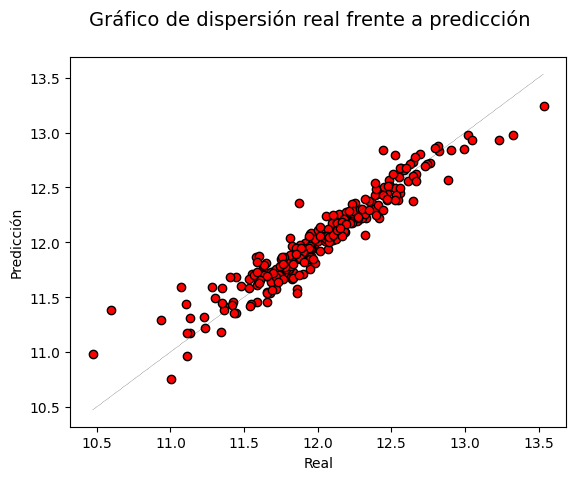

rmse:  0.1300082323720927


In [63]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [400],
    'learning_rate': [0.1],
    'max_depth': [3],
    'min_samples_split': [2],
    'min_samples_leaf': [1],
    'loss': ['huber']
}

# Inicializa el modelo
gbr = GradientBoostingRegressor(random_state=42)

# Configura GridSearchCV con el modelo y el rango de hiperparámetros
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, scoring='neg_mean_squared_error', n_jobs=-1)

# Realiza la búsqueda de hiperparámetros en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtiene los mejores hiperparámetros y el mejor modelo
best_params = grid_search.best_params_
best_gbr = grid_search.best_estimator_

# Imprime los mejores parámetros
print("Mejores parámetros:", best_params)

# Utiliza el mejor modelo para hacer predicciones
y_pred = best_gbr.predict(X_test)
cross_validation(best_gbr)

r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))
actual_vs_pred_plot(y_test,y_pred)
rmse(y_pred,y_test)



In [68]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Crear modelo de nivel superior
xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=175)

# Crear modelo de stacking
estimators = [
              
              ("Gradient Boosting Regressor", best_gbr),
              ("XGBoost1",xgb_model),
              ("Ridge",model_ridge),
             
              
              
              ]
reg = LinearRegression()
stacked1 = StackingRegressor(estimators=estimators, final_estimator=reg)

# Ajustamos
stacked1 = stacked1.fit(X_train, y_train)
y_pred = stacked1.predict(X_test)
rmse(y_pred, y_test)
cross_validation(stacked1)

r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))

rmse:  0.12457929683949191
Mean CV score:  0.1266185091950058
R-cuadrado: 0.92


In [81]:
from sklearn.ensemble import RandomForestRegressor

# Generamos un modelo
rforest = RandomForestRegressor(n_estimators=200,max_depth=13,random_state=42)

# Búsqueda en cuadrícula para encontrar el mejor valor de C, gamma y épsilon
param_grid  = {'n_estimators': [450],
               'max_depth': [13], 
               'min_samples_leaf': [2]}

# Establecemos la validación cruzada en 5 y el verbose en 1
clf = GridSearchCV(rforest, param_grid, cv = 5, n_jobs = -2, verbose=1)

# Ajustamos el modelo
clf.fit(X_train,y_train)

# Mostramos los mejores parámetros
clf.best_params_

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'max_depth': 13, 'min_samples_leaf': 2, 'n_estimators': 450}

Mean CV score:  0.14284738309635212
rmse:  0.1436906632564834
R-cuadrado: 0.89


<Figure size 1200x1200 with 0 Axes>

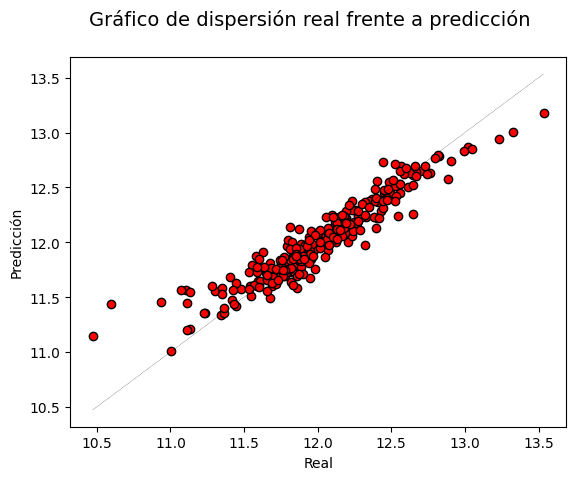

In [257]:
# Generamos el modelo con estos parámetros
rforest = RandomForestRegressor(n_estimators=450, max_depth=13, min_samples_leaf=2, random_state=42)

# Calculamos la validación cruzada
cross_validation(rforest)

# Ajustamos el modelo
model_rforest = rforest.fit(X_train, y_train,sample_weight=pesos_train)

# Predecimos el valor de SalePrice en el df de test
y6_pred_v = rforest.predict(X_test)

#Calculamos el error cuadrático medio
rmse(y6_pred_v, y_test)


# Calculamos coeficiente de determinación (R-cuadrado) 
y6_pred_v = rforest.predict(X_test)
r2 = r2_score(y_test, y6_pred_v)
print("R-cuadrado: {:.2f}".format(r2))

#Ploteamos el resultado
actual_vs_pred_plot(y_test,y6_pred_v)

rmse:  0.1227039678979703
Mean CV score:  0.12446983427277093
R-cuadrado: 0.92


<Figure size 1200x1200 with 0 Axes>

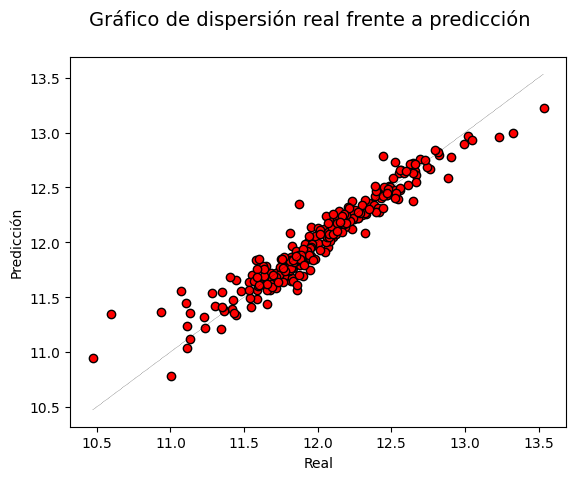

In [259]:
# Crear modelo de nivel superior
xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=175)

# Crear modelo de stacking
estimators = [
              
              ("Gradient Boosting Regressor", best_gbr),
              ("XGBoost1",xgb_model),
              ("Ridge",model_ridge),
              ("RF",model_rforest)
             
              
              
              ]
reg = LinearRegression()
stacked2 = StackingRegressor(estimators=estimators, final_estimator=reg)

# Ajustamos
stacked2 = stacked2.fit(X_train, y_train)
y_pred = stacked2.predict(X_test)
rmse(y_pred, y_test)
cross_validation(stacked2)
r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))
actual_vs_pred_plot(y_test,y_pred)

rmse:  0.12357464281936646
R-cuadrado: 0.92
0:	learn: 0.3941753	total: 1.02ms	remaining: 6.1s
200:	learn: 0.2329017	total: 272ms	remaining: 7.86s
400:	learn: 0.1726316	total: 487ms	remaining: 6.8s
600:	learn: 0.1470164	total: 670ms	remaining: 6.02s
800:	learn: 0.1329583	total: 845ms	remaining: 5.49s
1000:	learn: 0.1242170	total: 1.02s	remaining: 5.09s
1200:	learn: 0.1179378	total: 1.25s	remaining: 4.99s
1400:	learn: 0.1132324	total: 1.46s	remaining: 4.8s
1600:	learn: 0.1085702	total: 1.66s	remaining: 4.57s
1800:	learn: 0.1049849	total: 1.85s	remaining: 4.33s
2000:	learn: 0.1018238	total: 2.04s	remaining: 4.07s
2200:	learn: 0.0989327	total: 2.22s	remaining: 3.83s
2400:	learn: 0.0964828	total: 2.41s	remaining: 3.62s
2600:	learn: 0.0941131	total: 2.63s	remaining: 3.43s
2800:	learn: 0.0920060	total: 2.84s	remaining: 3.24s
3000:	learn: 0.0900643	total: 3.02s	remaining: 3.02s
3200:	learn: 0.0881287	total: 3.21s	remaining: 2.81s
3400:	learn: 0.0862468	total: 3.43s	remaining: 2.62s
3600:	learn

<Figure size 1200x1200 with 0 Axes>

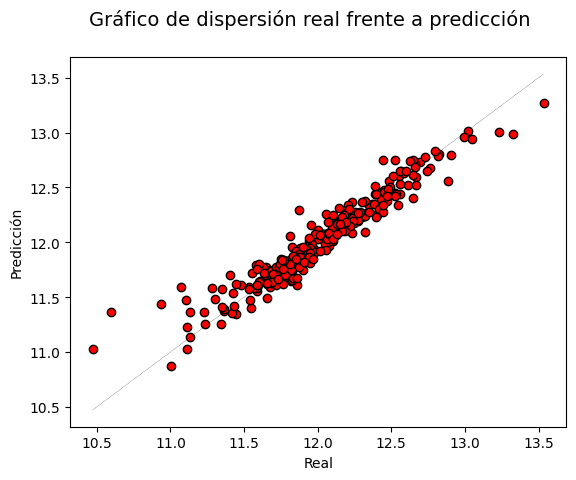

In [261]:
from catboost import CatBoostRegressor

params = {'iterations': 6000,
          'learning_rate': 0.0055,
          'depth': 4,
          'l2_leaf_reg': 5,
          'eval_metric':'RMSE',
          'early_stopping_rounds': 200,
          'verbose': 200,
          'random_seed': 42}
         
cat_f = CatBoostRegressor(**params)
catboost_model = cat_f.fit(X_train,y_train,
                     eval_set = (X_test,y_test),
                     verbose = False,sample_weight=pesos_train)

y_pred=catboost_model.predict(X_test)

rmse(y_pred, y_test)

r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))
cross_validation(catboost_model)

actual_vs_pred_plot(y_test,y_pred)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
20 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/s

Error cuadrático medio: 0.0709966858121521
Mean CV score:  0.2445568769104467
R-cuadrado: 0.62
0:	learn: 0.3941753	total: 5.33ms	remaining: 32s
200:	learn: 0.2329017	total: 245ms	remaining: 7.08s
400:	learn: 0.1726316	total: 454ms	remaining: 6.34s
600:	learn: 0.1470164	total: 633ms	remaining: 5.69s
800:	learn: 0.1329583	total: 831ms	remaining: 5.39s
1000:	learn: 0.1242170	total: 1.04s	remaining: 5.18s
1200:	learn: 0.1179378	total: 1.21s	remaining: 4.82s
1400:	learn: 0.1132324	total: 1.39s	remaining: 4.57s
1600:	learn: 0.1085702	total: 1.58s	remaining: 4.35s
1800:	learn: 0.1049849	total: 1.76s	remaining: 4.09s
2000:	learn: 0.1018238	total: 1.93s	remaining: 3.85s
2200:	learn: 0.0989327	total: 2.1s	remaining: 3.62s
2400:	learn: 0.0964828	total: 2.27s	remaining: 3.4s
2600:	learn: 0.0941131	total: 2.44s	remaining: 3.19s
2800:	learn: 0.0920060	total: 2.61s	remaining: 2.98s
3000:	learn: 0.0900643	total: 2.8s	remaining: 2.8s
3200:	learn: 0.0881287	total: 3.03s	remaining: 2.65s
3400:	learn: 0.0

<Figure size 1200x1200 with 0 Axes>

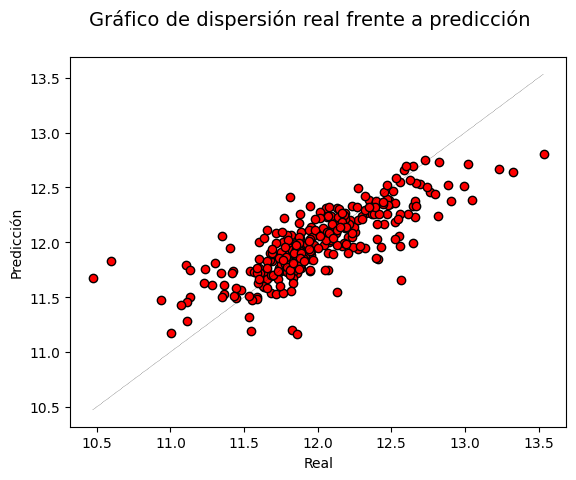

In [271]:
from sklearn.neighbors import KNeighborsRegressor
# Definimos el conjunto de parámetros a probar
param_grid = {"n_neighbors": [3, 5, 7, 9], "weights": ["uniform", "distance", "inverse"]}

# Instanciamos el modelo
model = KNeighborsRegressor()

# Realizamos la búsqueda de cuadrícula
gscv = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error")

# Entrenamos el modelo
gscv.fit(X_train, y_train)

# Obtenemos el mejor modelo
best_model_knn = gscv.best_estimator_

# Predecimos los valores de los datos de prueba
y_pred = best_model_knn.predict(X_test)

# Evaluamos el modelo
print("Error cuadrático medio:", mean_squared_error(y_test, y_pred))
cross_validation(best_model_knn)
r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))
cross_validation(catboost_model)

actual_vs_pred_plot(y_test,y_pred)


0:	learn: 0.3891694	total: 2.6ms	remaining: 15.6s
200:	learn: 0.2295158	total: 365ms	remaining: 10.5s
400:	learn: 0.1695907	total: 545ms	remaining: 7.61s
600:	learn: 0.1448194	total: 723ms	remaining: 6.5s
800:	learn: 0.1312569	total: 896ms	remaining: 5.81s
1000:	learn: 0.1220275	total: 1.07s	remaining: 5.34s
1200:	learn: 0.1159020	total: 1.25s	remaining: 4.98s
1400:	learn: 0.1110470	total: 1.42s	remaining: 4.67s
1600:	learn: 0.1069834	total: 1.6s	remaining: 4.41s
1800:	learn: 0.1032939	total: 1.77s	remaining: 4.14s
2000:	learn: 0.1000293	total: 1.95s	remaining: 3.9s
2200:	learn: 0.0979023	total: 2.13s	remaining: 3.67s
2400:	learn: 0.0960868	total: 2.3s	remaining: 3.44s
2600:	learn: 0.0938972	total: 2.47s	remaining: 3.23s
2800:	learn: 0.0915378	total: 2.65s	remaining: 3.02s
3000:	learn: 0.0892106	total: 2.82s	remaining: 2.82s
3200:	learn: 0.0871529	total: 3s	remaining: 2.62s
3400:	learn: 0.0850660	total: 3.17s	remaining: 2.42s
3600:	learn: 0.0831918	total: 3.35s	remaining: 2.23s
3800:	l

<Figure size 1200x1200 with 0 Axes>

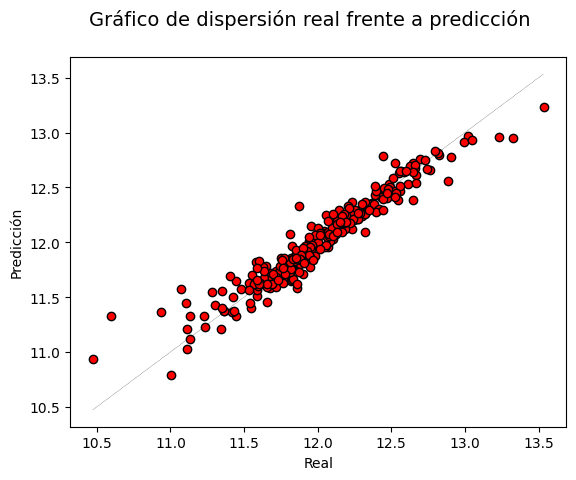

In [262]:
# Crear modelo de nivel superior
xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=175)

# Crear modelo de stacking
estimators = [
              
              ("Gradient Boosting Regressor", best_gbr),
              ("XGBoost1",xgb_model),
              ("Ridge",model_ridge),
              ("Catboost", catboost_model)
              
              ]
reg = LinearRegression()
stacked3 = StackingRegressor(estimators=estimators, final_estimator=reg)

# Ajustamos
stacked3 = stacked3.fit(X_train, y_train)
y_pred = stacked3.predict(X_test)
rmse(y_pred, y_test)
r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))
actual_vs_pred_plot(y_test,y_pred)

In [ ]:
from lightgbm import LGBMRegressor
param_grid = {
    "n_estimators": [300],
    "learning_rate": [0.01],
    "max_depth": [ 5],
    "min_child_samples": [10],
    "subsample": [ 0.7],
    "colsample_bytree": [ 0.8],
}

# Instanciamos el modelo
model = LGBMRegressor()

# Realizamos la búsqueda de cuadrícula
gscv = GridSearchCV(model, param_grid, scoring="neg_mean_squared_error")

# Entrenamos el modelo
gscv.fit(X_train, y_train)

# Obtenemos el mejor modelo
best_model = gscv.best_estimator_

# Predecimos los valores de los datos de prueba
y_pred = best_model.predict(X_test)
rmse(y_pred, y_test)
r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))
actual_vs_pred_plot(y_test,y_pred)


: 

0:	learn: 0.3891694	total: 2.11ms	remaining: 12.7s
200:	learn: 0.2295158	total: 537ms	remaining: 15.5s
400:	learn: 0.1695907	total: 755ms	remaining: 10.5s
600:	learn: 0.1448194	total: 938ms	remaining: 8.42s
800:	learn: 0.1312569	total: 1.17s	remaining: 7.62s
1000:	learn: 0.1220275	total: 1.38s	remaining: 6.88s
1200:	learn: 0.1159020	total: 1.59s	remaining: 6.34s
1400:	learn: 0.1110470	total: 1.76s	remaining: 5.77s
1600:	learn: 0.1069834	total: 1.94s	remaining: 5.32s
1800:	learn: 0.1032939	total: 2.11s	remaining: 4.91s
2000:	learn: 0.1000293	total: 2.28s	remaining: 4.56s
2200:	learn: 0.0979023	total: 2.46s	remaining: 4.24s
2400:	learn: 0.0960868	total: 2.63s	remaining: 3.94s
2600:	learn: 0.0938972	total: 2.81s	remaining: 3.67s
2800:	learn: 0.0915378	total: 2.99s	remaining: 3.41s
3000:	learn: 0.0892106	total: 3.17s	remaining: 3.17s
3200:	learn: 0.0871529	total: 3.35s	remaining: 2.93s
3400:	learn: 0.0850660	total: 3.52s	remaining: 2.69s
3600:	learn: 0.0831918	total: 3.7s	remaining: 2.46s


<Figure size 1200x1200 with 0 Axes>

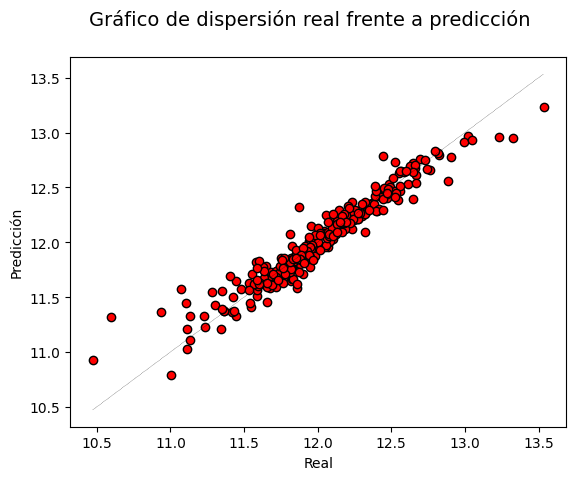

In [272]:
# Crear modelo de nivel superior
xgb_model = XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=175)

# Crear modelo de stacking
estimators = [
              
              ("Gradient Boosting Regressor", best_gbr),
              ("XGBoost1",xgb_model),
              ("Ridge",model_ridge),
              ("Catboost", catboost_model),
              ("knn",best_model_knn),
              ("Rforest", model_rforest)
              
              ]
reg = LinearRegression()
stacked3 = StackingRegressor(estimators=estimators, final_estimator=reg)

# Ajustamos
stacked3 = stacked3.fit(X_train, y_train)
y_pred = stacked3.predict(X_test)
rmse(y_pred, y_test)
r2 = r2_score(y_test, y_pred)
print("R-cuadrado: {:.2f}".format(r2))
actual_vs_pred_plot(y_test,y_pred)

<Figure size 1200x1200 with 0 Axes>

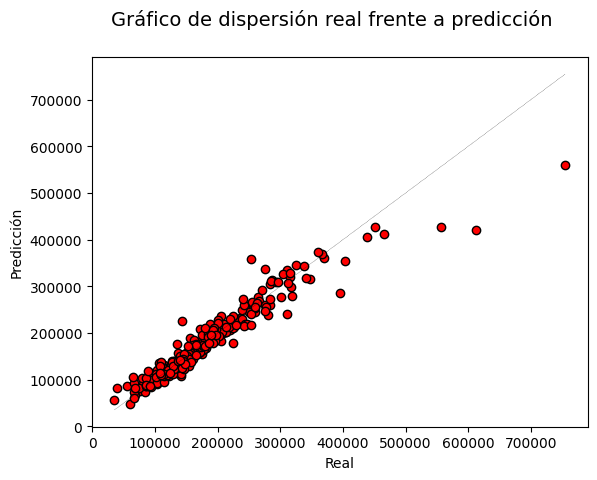

In [273]:
actual_vs_pred_plot(np.exp(y_test)-1,np.exp(y_pred)-1)

### Cambiamos el dataframe de Test

In [20]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [21]:
test_data["Alley"].fillna("None", inplace=True)
test_data["FireplaceQu"].fillna("None", inplace=True)
test_data["PoolQC"].fillna("None", inplace=True)
test_data["Fence"].fillna("None", inplace=True)
test_data["MiscFeature"].fillna("None", inplace=True)
test_data["MasVnrType"].fillna("None", inplace=True)
test_data["MasVnrArea"].fillna(0, inplace=True)

test_data["BsmtQual"].fillna("None", inplace=True)
test_data["BsmtCond"].fillna("None", inplace=True)
test_data["BsmtExposure"].fillna("None", inplace=True)
test_data["BsmtFinType1"].fillna("None", inplace=True)
test_data["BsmtFinType2"].fillna("None", inplace=True)

test_data["GarageFinish"].fillna("None", inplace=True)
test_data["GarageType"].fillna("None", inplace=True)
test_data["GarageQual"].fillna("None", inplace=True)
test_data["GarageCond"].fillna("None", inplace=True)
test_data["GarageYrBlt"].fillna("None", inplace=True)


test_data["LotFrontage"].fillna(test_data["LotFrontage"].mean(), inplace=True)
test_data["MSZoning"].fillna(test_data["MSZoning"].mode()[0], inplace=True)
test_data["Electrical"].fillna(test_data["Electrical"].mode()[0], inplace=True)
test_data["Utilities"].fillna(test_data["Utilities"].mode()[0], inplace=True)
test_data["Functional"].fillna(test_data["Functional"].mode()[0], inplace=True)
test_data["SaleType"].fillna(test_data["SaleType"].mode()[0], inplace=True)

/var/folders/b9/4nb2k3j92lx258swghfc_3q00000gn/T/ipykernel_17071/2103081592.py:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_data["GarageYrBlt"].fillna("None", inplace=True)


In [22]:
#Cambiammos la varible HeatingQC y Heating, que se refire a la calidad de la calefacción y al tipo ordenado de mejor a peor, a números 
dic_HeatingQC= {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
dic_Heating={'GasA': 6, 'GasW': 5, 'OthW': 4, 'Wall': 3, 'Grav': 2, 'Floor': 1}
test_data['HeatingQC']= test_data['HeatingQC'].replace(dic_HeatingQC)
test_data['Heating']= test_data['Heating'].replace(dic_Heating)
test_data[['HeatingQC','Heating']]

dic_Alley = {"Grvl": 1, "Pave": 2, "None": 0}
test_data['Alley'] = test_data['Alley'].replace(dic_Alley)

dic_BsmtCond = {"No_Bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
test_data['BsmtCond'] = test_data['BsmtCond'].replace(dic_BsmtCond)

dic_BsmtExposure = {"No_Bsmt": 0, "Mn": 1, "Av": 2, "Gd": 3, "No": 0}
test_data['BsmtExposure'] = test_data['BsmtExposure'].replace(dic_BsmtExposure)

dic_BsmtFinType1 = {"No_Bsmt": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
test_data['BsmtFinType1'] = test_data['BsmtFinType1'].replace(dic_BsmtFinType1)

dic_BsmtFinType2 = {"No_Bsmt": 0, "Unf": 1, "LwQ": 2, "Rec": 3, "BLQ": 4, "ALQ": 5, "GLQ": 6}
test_data['BsmtFinType2'] = test_data['BsmtFinType2'].replace(dic_BsmtFinType2)

dic_BsmtQual = {"No_Bsmt": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
test_data['BsmtQual'] = test_data['BsmtQual'].replace(dic_BsmtQual)

dic_ExterCond = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
test_data['ExterCond'] = test_data['ExterCond'].replace(dic_ExterCond)

dic_ExterQual = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
test_data['ExterQual'] = test_data['ExterQual'].replace(dic_ExterQual)

dic_GarageCond = {"No_Garage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
test_data['GarageCond'] = test_data['GarageCond'].replace(dic_GarageCond)

dic_GarageQual = {"No_Garage": 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
test_data['GarageQual'] = test_data['GarageQual'].replace(dic_GarageQual)

dic_PoolQC = {"None": 0, "Fa": 1, "TA": 2, "Gd": 3, "Ex": 4}
test_data['PoolQC'] = test_data['PoolQC'].replace(dic_PoolQC)

dic_Functional = {"Sal": 1, "Sev": 2, "Maj2": 3, "Maj1": 4, "Mod": 5, "Min2": 6, "Min1": 7, "Typ": 8}
test_data['Functional'] = test_data['Functional'].replace(dic_Functional)

dic_KitchenQual = {"Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
test_data['KitchenQual'] = test_data['KitchenQual'].replace(dic_KitchenQual)

dic_LandSlope = {"Sev": 1, "Mod": 2, "Gtl": 3}
test_data['LandSlope'] = test_data['LandSlope'].replace(dic_LandSlope)

dic_LotShape = {"IR3": 1, "IR2": 2, "IR1": 3, "Reg": 4}
test_data['LotShape'] = test_data['LotShape'].replace(dic_LotShape)

dic_PavedDrive = {"N": 0, "P": 1, "Y": 2}
test_data['PavedDrive'] = test_data['PavedDrive'].replace(dic_PavedDrive)
dic_Street = {"Grvl": 1, "Pave": 2}
test_data['Street'] = test_data['Street'].replace(dic_Street)
dic_Utilities = {"ELO": 1, "NoSeWa": 2, "NoSewr": 3, "AllPub": 4}
test_data['Utilities'] = test_data['Utilities'].replace(dic_Utilities)
dic_SaleCondition= {"Partial": 1, "Normal": 2, "Alloca": 3, "Family": 4,"Abnorml": 5, "Adjand": 6}
test_data['SaleCondition'] = test_data['SaleCondition'].replace(dic_SaleCondition)
dic_SaleType= {"New": 1, "Con": 2, "CWD": 3, "ConLI": 4,"WD": 5, "COD": 6, "ConLw": 7, "ConLD": 8, "Oth":9 }
test_data['SaleType'] = test_data['SaleType'].replace(dic_SaleType)

In [31]:
test_data=test_data.set_index("Id")

In [24]:

dummies_cols_test = test_data.select_dtypes(include=object).columns
dummies_cols_test = dummies_cols_test[dummies_cols_test.isin(dummies_cols)]
dummies_test = pd.get_dummies(test_data[dummies_cols_test], dtype=int)
dummies_test = dummies_test.reindex(columns=dummies.columns, fill_value=0)
test_data_processed = pd.concat([test_data[int_cols], dummies_test], axis=1)


In [34]:
test_data_processed=test_data_processed.set_index(test_data.index)

## Seguimos teniendo NAN en algunas variables. 

In [68]:

test_data_processed= test_data_processed.fillna(test_data_processed.mean())


### Hacemos las predicciones

In [103]:
test_data_processed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1459 entries, 1461 to 2919
Columns: 352 entries, MSSubClass to SaleCondition_AdjLand
dtypes: float64(11), int64(341)
memory usage: 3.9 MB


In [104]:
test_data_processed.to_csv("test_data_clean")

In [6]:
test_data_processed= pd.read_csv("/Users/aitormentxaka/Desktop/Data science/proyectos/Modelo machine learning regresión/test_data_clean")

In [7]:
test_data_processed

,Id,MSSubClass,LotFrontage,LotArea,Street,Alley,LotShape,Utilities,LandSlope,OverallQual,...,MiscFeature_None,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,SaleCondition_1,SaleCondition_2,SaleCondition_3,SaleCondition_4,SaleCondition_5,SaleCondition_AdjLand
0,1461,20,80.0,11622,2,0,4,4,3,5,...,1,0,0,0,0,1,0,0,0,0
1,1462,20,81.0,14267,2,0,3,4,3,6,...,0,0,0,0,0,1,0,0,0,0
2,1463,60,74.0,13830,2,0,3,4,3,5,...,1,0,0,0,0,1,0,0,0,0
3,1464,60,78.0,9978,2,0,3,4,3,6,...,1,0,0,0,0,1,0,0,0,0
4,1465,120,43.0,5005,2,0,3,4,3,8,...,1,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,21.0,1936,2,0,4,4,3,4,...,1,0,0,0,0,1,0,0,0,0
1455,2916,160,21.0,1894,2,0,4,4,3,4,...,1,0,0,0,0,0,0,0,1,0
1456,2917,20,160.0,20000,2,0,4,4,3,5,...,1,0,0,0,0,0,0,0,1,0
1457,2918,85,62.0,10441,2,0,4,4,3,5,...,0,0,1,0,0,1,0,0,0,0


In [73]:
predicciones1= model_ridge.predict(test_data_processed)
predicciones_dict1 = {'id': test_data_processed.index, 'SalePrice':predicciones1}
respuestas1 = pd.DataFrame(predicciones_dict1)
respuestas1.to_csv("predicciones1_precio_casas_kaggle.csv", index=False)

In [80]:
predicciones2= stacked1.predict(test_data_processed)
predicciones_dict2 = {'id': test_data_processed.index, 'SalePrice':predicciones2}
respuestas2 = pd.DataFrame(predicciones_dict2)
respuestas2.to_csv("predicciones2_precio_casas_kaggle.csv", index=False)

In [88]:
predicciones3= stacked2.predict(test_data_processed)
predicciones_dict3 = {'id': test_data_processed.index, 'SalePrice':predicciones3}
respuestas3 = pd.DataFrame(predicciones_dict3)
respuestas3.to_csv("predicciones3_precio_casas_kaggle.csv", index=False)

In [113]:
predicciones4= stacked2.predict(test_data_processed)
predicciones_dict4 = {'id': test_data_processed.index, 'SalePrice':np.exp(predicciones4)-1}
respuestas4 = pd.DataFrame(predicciones_dict4)
respuestas4.to_csv("predicciones4_precio_casas_kaggle.csv", index=False)

In [117]:
predicciones5= stacked3.predict(test_data_processed)
predicciones_dict5 = {'id': test_data_processed.index, 'SalePrice':np.exp(predicciones5)-1}
respuestas5 = pd.DataFrame(predicciones_dict5)
respuestas5.to_csv("predicciones5_precio_casas_kaggle.csv", index=False)

In [136]:
predicciones6= stacked3.predict(test_featured)
predicciones_dict6 = {'id': test_data_processed.index, 'SalePrice':np.exp(predicciones6)-1}
respuestas6 = pd.DataFrame(predicciones_dict6)
respuestas6.to_csv("predicciones6_precio_casas_kaggle.csv", index=False)

In [201]:
predicciones7= stacked3.predict(np.log1p(test_data_processed))
predicciones_dict7 = {'id': test_data_processed.index, 'SalePrice':np.exp(predicciones7)-1}
respuestas7 = pd.DataFrame(predicciones_dict7)
respuestas7.to_csv("predicciones8_precio_casas_kaggle.csv", index=False)